
This is the lstm model for forecasting kospi volatility

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr


In [3]:
data, target = dr.read_data(window=22)
split_index = int(len(data)*0.8)
data.info()
target.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2434 non-null   object 
 1   Daily_trading_range  2434 non-null   float64
 2   Log_Volume_change    2434 non-null   float64
 3   Daily_return         2434 non-null   float64
 4   Daily_log_return     2434 non-null   float64
 5   Index                2434 non-null   float64
 6   past_vol             2434 non-null   float64
dtypes: float64(6), object(1)
memory usage: 133.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2413 entries, 0 to 2412
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2413 non-null   float64
dtypes: float64(1)
memory usage: 37.7 KB


In [4]:
def data_prep(data, target, split_index, n_ahead=1, window=22):


    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    y_values = target
    x_values = data
    print(x_values.info())

    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    trainX = np.array(scaled_x[:split_index])
    testX = np.array(scaled_x[split_index:])
    trainY = np.array(scaled_y[:split_index])
    testY = np.array(scaled_y[split_index:])

    Xtrain = np.array([])
    ytrain = np.array([])
    Xtest = np.array([])
    ytest = np.array([])

    for i in range(window, len(trainX)-n_ahead-window):
        candidate = trainX[i - window:i, :trainX.shape[1]]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i:i+n_ahead].shape[1])

        if i==window:
            Xtrain = candidate
            ytrain = y_candidate
            continue

        Xtrain = np.append(Xtrain, candidate, axis=0)
        ytrain = np.append(ytrain, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])

    for i in range(window, len(testX)-n_ahead-window):
        test_candidate = testX[i - window:i, :testX.shape[1]]
        test_candidate = test_candidate.reshape(1, test_candidate.shape[0], test_candidate.shape[1])
        test_y_can = testY[i-window:i-window+n_ahead].reshape(1, testY[i-window:i-window+n_ahead].shape[0], testY[i-window:i-window+n_ahead].shape[1])

        if(i==window):
            Xtest = test_candidate
            ytest = test_y_can
            continue
        Xtest = np.append(Xtest, test_candidate, axis=0)
        ytest = np.append(ytest, test_y_can, axis=0)

        # Xtest.append(test_candidate)
        # ytest.append(testY[i:i+n_ahead])
    # Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    #
    # Xtest, ytest = (np.array(Xtest), np.array(ytest))
    # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler

In [18]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data, target, split_index=split_index, window=22, n_ahead=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2434 entries, 0 to 2433
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2434 non-null   float64
 1   Log_Volume_change    2434 non-null   float64
 2   Daily_log_return     2434 non-null   float64
 3   Index                2434 non-null   float64
 4   past_vol             2434 non-null   float64
dtypes: float64(5)
memory usage: 95.2 KB
None
(1902, 22, 5)
(1902, 1, 1)
-----
(442, 22, 5)
(442, 1, 1)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error
from tensorflow import keras
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

In [21]:
def create_model(neurons1=1, neurons2=1, lr=0.001):
    if(K.backend() == 'tensorflow'):
        K.clear_session()
    model = Sequential()
    model.add(LSTM(units=neurons1, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=neurons2,return_sequences=False))
    model.add(Dropout(0.2))
    # model.add(LSTM(units=neurons3, return_sequences=False))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=opt)
    return model
# model.fit(Xtrain, ytrain, batch_size=16, epochs=150, validation_split=0.1, shuffle=False)

In [22]:
model = create_model(neurons1=32, neurons2=20, lr=0.0002)
model.fit(Xtrain, ytrain, batch_size=32, epochs=50, shuffle=False,validation_data=(Xtest, ytest))

Epoch 1/50
60/60 [==============================] - 6s 37ms/step - loss: 0.2046 - val_loss: 0.0999

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 22, 32)            4864      
_________________________________________________________________
dropout (Dropout)            (None, 22, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 9,125
Trainable params: 9,125
Non-trainable params: 0
_________________________________________________________________


In [24]:
forecast = model.predict(Xtest)
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

print(forecast.shape)
print(ytest.shape)

(442, 1)
(442, 1)


In [25]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

In [26]:
testScore = mean_squared_error(y_true=ytest, y_pred=forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(y_true=ytest, y_pred=forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(y_pred=rev_forecast, y_true=rev_ytest)
print("test Score: {score} MAPE".format(score=mape))
mae = mean_absolute_error(y_pred=rev_forecast, y_true=rev_ytest)
print("test Score: {score} MAE".format(score=mae))


test Score: 0.0013819386096234816 MSE
test Score: 0.03717443489312893 RMSE
test Score: 0.06725239152818278 MAPE
test Score: 0.012865757822223956 MAE


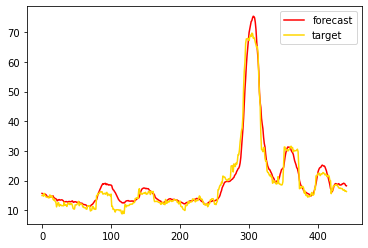

In [21]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [19]:
# previous_model = keras.models.load_model('models/multi_layer_lstm_model')
regressor = KerasRegressor(build_fn=create_model, epochs=50, verbose=0,batch_size=32)

In [27]:
params = dict(neurons1=[10,20,32,64],
              neurons2=[10,20,32,64],
              epochs=[50,100],
              lr=[0.001,0.0005])
grid = GridSearchCV(estimator=regressor, param_grid=params, verbose=10)
grid_result = grid.fit(Xtrain,ytrain)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 1/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  42.1s
[CV 2/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 2/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  42.6s
[CV 3/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 3/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  42.4s
[CV 4/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 4/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  42.2s
[CV 5/5; 1/64] START epochs=50, lr=0.001, neurons1=10, neurons2=10..............
[CV 5/5; 1/64] END epochs=50, lr=0.001, neurons1=10, neurons2=10; total time=  41.9s
[CV 1/5; 2/64] START epochs=50, lr=0.001, neurons1=10, neurons2=20..............
[CV 1/5; 2/64] END epochs=5

In [33]:
grid_forecast = grid_result.predict(Xtest)
print('Best score is: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best score is: -0.0021650510607287288 using {'epochs': 100, 'lr': 0.001, 'neurons1': 64, 'neurons2': 64}


In [34]:
grid_forecast = grid_forecast.reshape(grid_forecast.shape[0],1)
rev_gridforecast = scaler.inverse_transform(grid_forecast)
rev_ytest = scaler.inverse_transform(ytest)

In [35]:
import metrics as mt

In [36]:
mt.testScore(rev_gridforecast, rev_ytest)

MSE Score: 4.747258409866969e-05
RMSE Score: 0.006890035130437993
MAPE Score: 0.009183053666995188
MAE Score: 0.002686297805724392


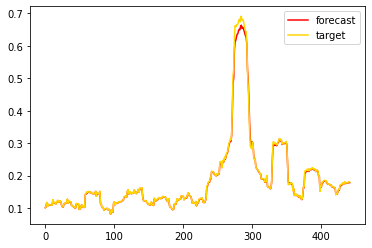

In [37]:
plt.plot(rev_gridforecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()


In [139]:
model = Sequential()
model.add(LSTM(2, return_sequences=False,input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(5, activation='tanh'))
model.add(Dense(20, activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=opt)
model.fit(Xtrain, ytrain, epochs=150, batch_size=16)

Epoch 1/150
114/114 [==============================] - 3s 8ms/step - loss: 0.0140

In [140]:
forecast = model.predict(Xtest)

In [141]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

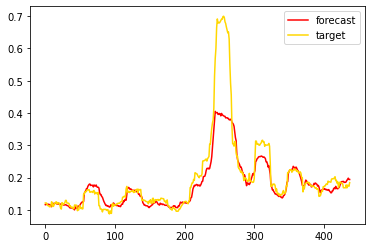

In [142]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [70]:
testScore = mean_squared_error(ytest, forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(ytest, forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.003428106869351618 MSE
test Score: 0.058550037312982285 RMSE
test Score: 0.13546836301356305 MAPE


In [60]:
# model.save("models/single_layer_lstm_model")

## Experiment settings

Dataset: KOSPI index from Jan, 2011 to Dec, 2020\
Included data in default: Daily log return, Daily trading range, Log volume change\
Additional data for hybrid: Next prediction by GARCH and GJR-GARCH

- Loss function: mean_squared_error
- Optimizer: Adam
- epochs: 20
- batch_size: 16

## Experiment results


- Single-layer lstm model (32 units)
    * Training error: 0.0042, Validation error: 0.0031
    * MSE: 0.0032
    * RMSE: 0.0568
    * MAPE 0.1912

![title](images/single_layer_model_pred.png)

- Multi-layer lstm model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0045, Validation error: 0.0024
    * MSE: 0.0023
    * RMSE 0.0484
    * MAPE: 0.1701
    
![title](images/multi_layer_model_pred.png)

- Single-layer hybrid model (32 units)
    * Training error: 0.0016, Validation error: 0.0001
    * MSE: 0.0007
    * RMSE: 0.0269
    * MAPE: 0.0924

![title](images/single_layer_hybrid_pred.png)

- Multi-layer hybrid model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0024, Validation error: 0.0001
    * MSE: 0.0008
    * RMSE: 0.0274
    * MAPE: 0.0935
    
![title](images/multi_layer_hybrid_pred.png)